In [ ]:
# Environment Setup & Configuration
# Check for GPU
!nvidia-smi

# Install SEG-Y library
!pip install segyio

import os
import gc
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
import segyio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from PIL import Image
from io import BytesIO

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# --- CONFIGURATION (FAST MODE) ---
class ProjectConfig:
    """Central configuration for the Infinite Earth Project."""
    SEGY_PATH = "/content/drive/MyDrive/Seismic_data.sgy" # Change if needed
    PATCH_SIZE = 128          # Small patches for fast training
    BATCH_SIZE = 16           # Efficient batch size
    LEARNING_RATE = 0.0002
    EPOCHS = 10               # Fast training cycle
    TRACE_DROP_PROB = 0.5     # 50% of traces will be deleted
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on device: {ProjectConfig.DEVICE}")
print("Configuration: Fast Mode (128x128 Patches)")

Sun Feb  1 07:02:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# --- 1. DATA INGESTION & PREPROCESSING ---

def load_seismic_volume(path: str) -> Optional[np.ndarray]:
    """
    Efficiently loads a SEGY volume into memory using C-optimized routines.
    Converts data to Float32 to reduce memory footprint by 50%.

    Args:
        path (str): Path to the .sgy file.

    Returns:
        np.ndarray: The 2D seismic array (Samples, Traces).
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Seismic file not found at: {path}")

    try:
        print(f"[INFO] Loading seismic data from {os.path.basename(path)}...")
        with segyio.open(path, ignore_geometry=True) as f:
            # Vectorized load (Avoids Python loops for speed)
            data = segyio.tools.collect(f.trace[:])

            # Transpose to (Samples, Traces) and cast to float32
            data = data.T.astype(np.float32)

            print(f"[SUCCESS] Loaded Volume. Shape: {data.shape}")
            print(f"[INFO] Memory Usage: {data.nbytes / 1024**3:.2f} GB")
            return data

    except Exception as e:
        print(f"[ERROR] Failed to load SEGY: {e}")
        return None

class SeismicReconstructionDataset(Dataset):
    """
    Custom PyTorch Dataset that generates self-supervised training pairs
    by artificially corrupting real seismic data on-the-fly.
    """
    def __init__(self, data: np.ndarray, patch_size: int = 256):
        self.data = data
        self.patch_size = patch_size
        self.h, self.w = self.data.shape
        self.epoch_length = 1500  # Virtual epoch length (number of random crops per epoch)

        # Robust Amplitude Normalization (99th Percentile Clipping)
        # Prevents high-amplitude noise/outliers from destabilizing gradients.
        self.scale_max = np.percentile(np.abs(self.data), 99)
        self.data = np.clip(self.data, -self.scale_max, self.scale_max) / (self.scale_max + 1e-6)

    def __len__(self) -> int:
        return self.epoch_length

    def _apply_physics_corruption(self, patch: torch.Tensor) -> torch.Tensor:
        """
        Simulates geological data loss scenarios:
        1. Trace Decimation (Randomly missing traces)
        2. Acquisition Gaps (Consecutive missing traces)
        """
        masked = patch.clone()
        _, h, w = patch.shape

        # Stochastic Decision: 50% chance of Gap vs. Sparse Decimation
        if np.random.rand() > 0.5:
            # Scenario 1: Random Trace Decimation (Simulates sparse receiver sampling)
            # Drop 20% to 50% of traces randomly
            drop_prob = np.random.uniform(0.2, 0.5)
            mask_vec = torch.rand(1, 1, w) > drop_prob
            masked = masked * mask_vec.float()
        else:
            # Scenario 2: Acquisition Gap (Simulates equipment failure/obstacle)
            gap_width = np.random.randint(20, 60)
            if w - gap_width > 0:
                start_idx = np.random.randint(0, w - gap_width)
                masked[:, :, start_idx : start_idx + gap_width] = 0.0

        return masked

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        # Random Crop Logic
        y = np.random.randint(0, max(0, self.h - self.patch_size) + 1)
        x = np.random.randint(0, max(0, self.w - self.patch_size) + 1)

        patch_np = self.data[y : y + self.patch_size, x : x + self.patch_size]

        # Padding for edge cases
        if patch_np.shape != (self.patch_size, self.patch_size):
            padded = np.zeros((self.patch_size, self.patch_size), dtype=np.float32)
            padded[:patch_np.shape[0], :patch_np.shape[1]] = patch_np
            patch_np = padded

        # Convert to Tensor (Channel, Height, Width)
        real_tensor = torch.from_numpy(patch_np).unsqueeze(0)
        masked_tensor = self._apply_physics_corruption(real_tensor)

        return {"real": real_tensor, "masked": masked_tensor}

In [5]:
# @title 3. Deep Learning Model (U-Net Generator)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super(UNetGenerator, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False)]
            if normalize: layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_feat, out_feat, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_feat),
                nn.ReLU(inplace=True)
            ]
            if dropout: layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        # Encoder
        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)

        # Decoder
        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 256)
        self.up3 = up_block(512, 128)
        self.up4 = up_block(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], 1))
        u3 = self.up3(torch.cat([u2, d3], 1))
        u4 = self.up4(torch.cat([u3, d2], 1))
        return self.final(torch.cat([u4, d1], 1))

generator = UNetGenerator().to(ProjectConfig.DEVICE)
print("Generator Model initialized.")

Generator Model initialized.


In [8]:
full_data = None
try:
    full_data = load_seismic_volume(ProjectConfig.SEGY_PATH)
    dataset = SeismicDataset(full_data, patch_size=ProjectConfig.PATCH_SIZE)
    dataloader = DataLoader(dataset, batch_size=ProjectConfig.BATCH_SIZE, shuffle=True)
    print(f"Dataset created with {len(dataset)} patches.")
except Exception as e:
    print(f"⚠️ Warning: Could not load SEG-Y file ({e}). You can still run Demos 6 & 7 if model is pre-trained or for testing.")

criterion = nn.L1Loss()
optimizer_G = optim.Adam(generator.parameters(), lr=ProjectConfig.LEARNING_RATE, betas=(0.5, 0.999))

if full_data is not None:
    print(f"Starting Training for {ProjectConfig.EPOCHS} epochs...")
    generator.train()

    for epoch in range(ProjectConfig.EPOCHS):
        total_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(ProjectConfig.DEVICE).float(), targets.to(ProjectConfig.DEVICE).float()

            optimizer_G.zero_grad()
            fake_images = generator(inputs)
            loss = criterion(fake_images, targets)
            loss.backward()
            optimizer_G.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{ProjectConfig.EPOCHS}] Loss: {total_loss/len(dataloader):.4f}")

    print("Training Complete.")

Loading seismic data from: /content/drive/MyDrive/Seismic_data.sgy
Data Loaded. Shape: (462, 600515)
Dataset created with 56292 patches.
Starting Training for 10 epochs...
Epoch [1/10] Loss: 0.0771
Epoch [2/10] Loss: 0.0615
Epoch [3/10] Loss: 0.0592
Epoch [4/10] Loss: 0.0578
Epoch [5/10] Loss: 0.0566
Epoch [6/10] Loss: 0.0557
Epoch [7/10] Loss: 0.0547
Epoch [8/10] Loss: 0.0536
Epoch [9/10] Loss: 0.0524
Epoch [10/10] Loss: 0.0520
Training Complete.


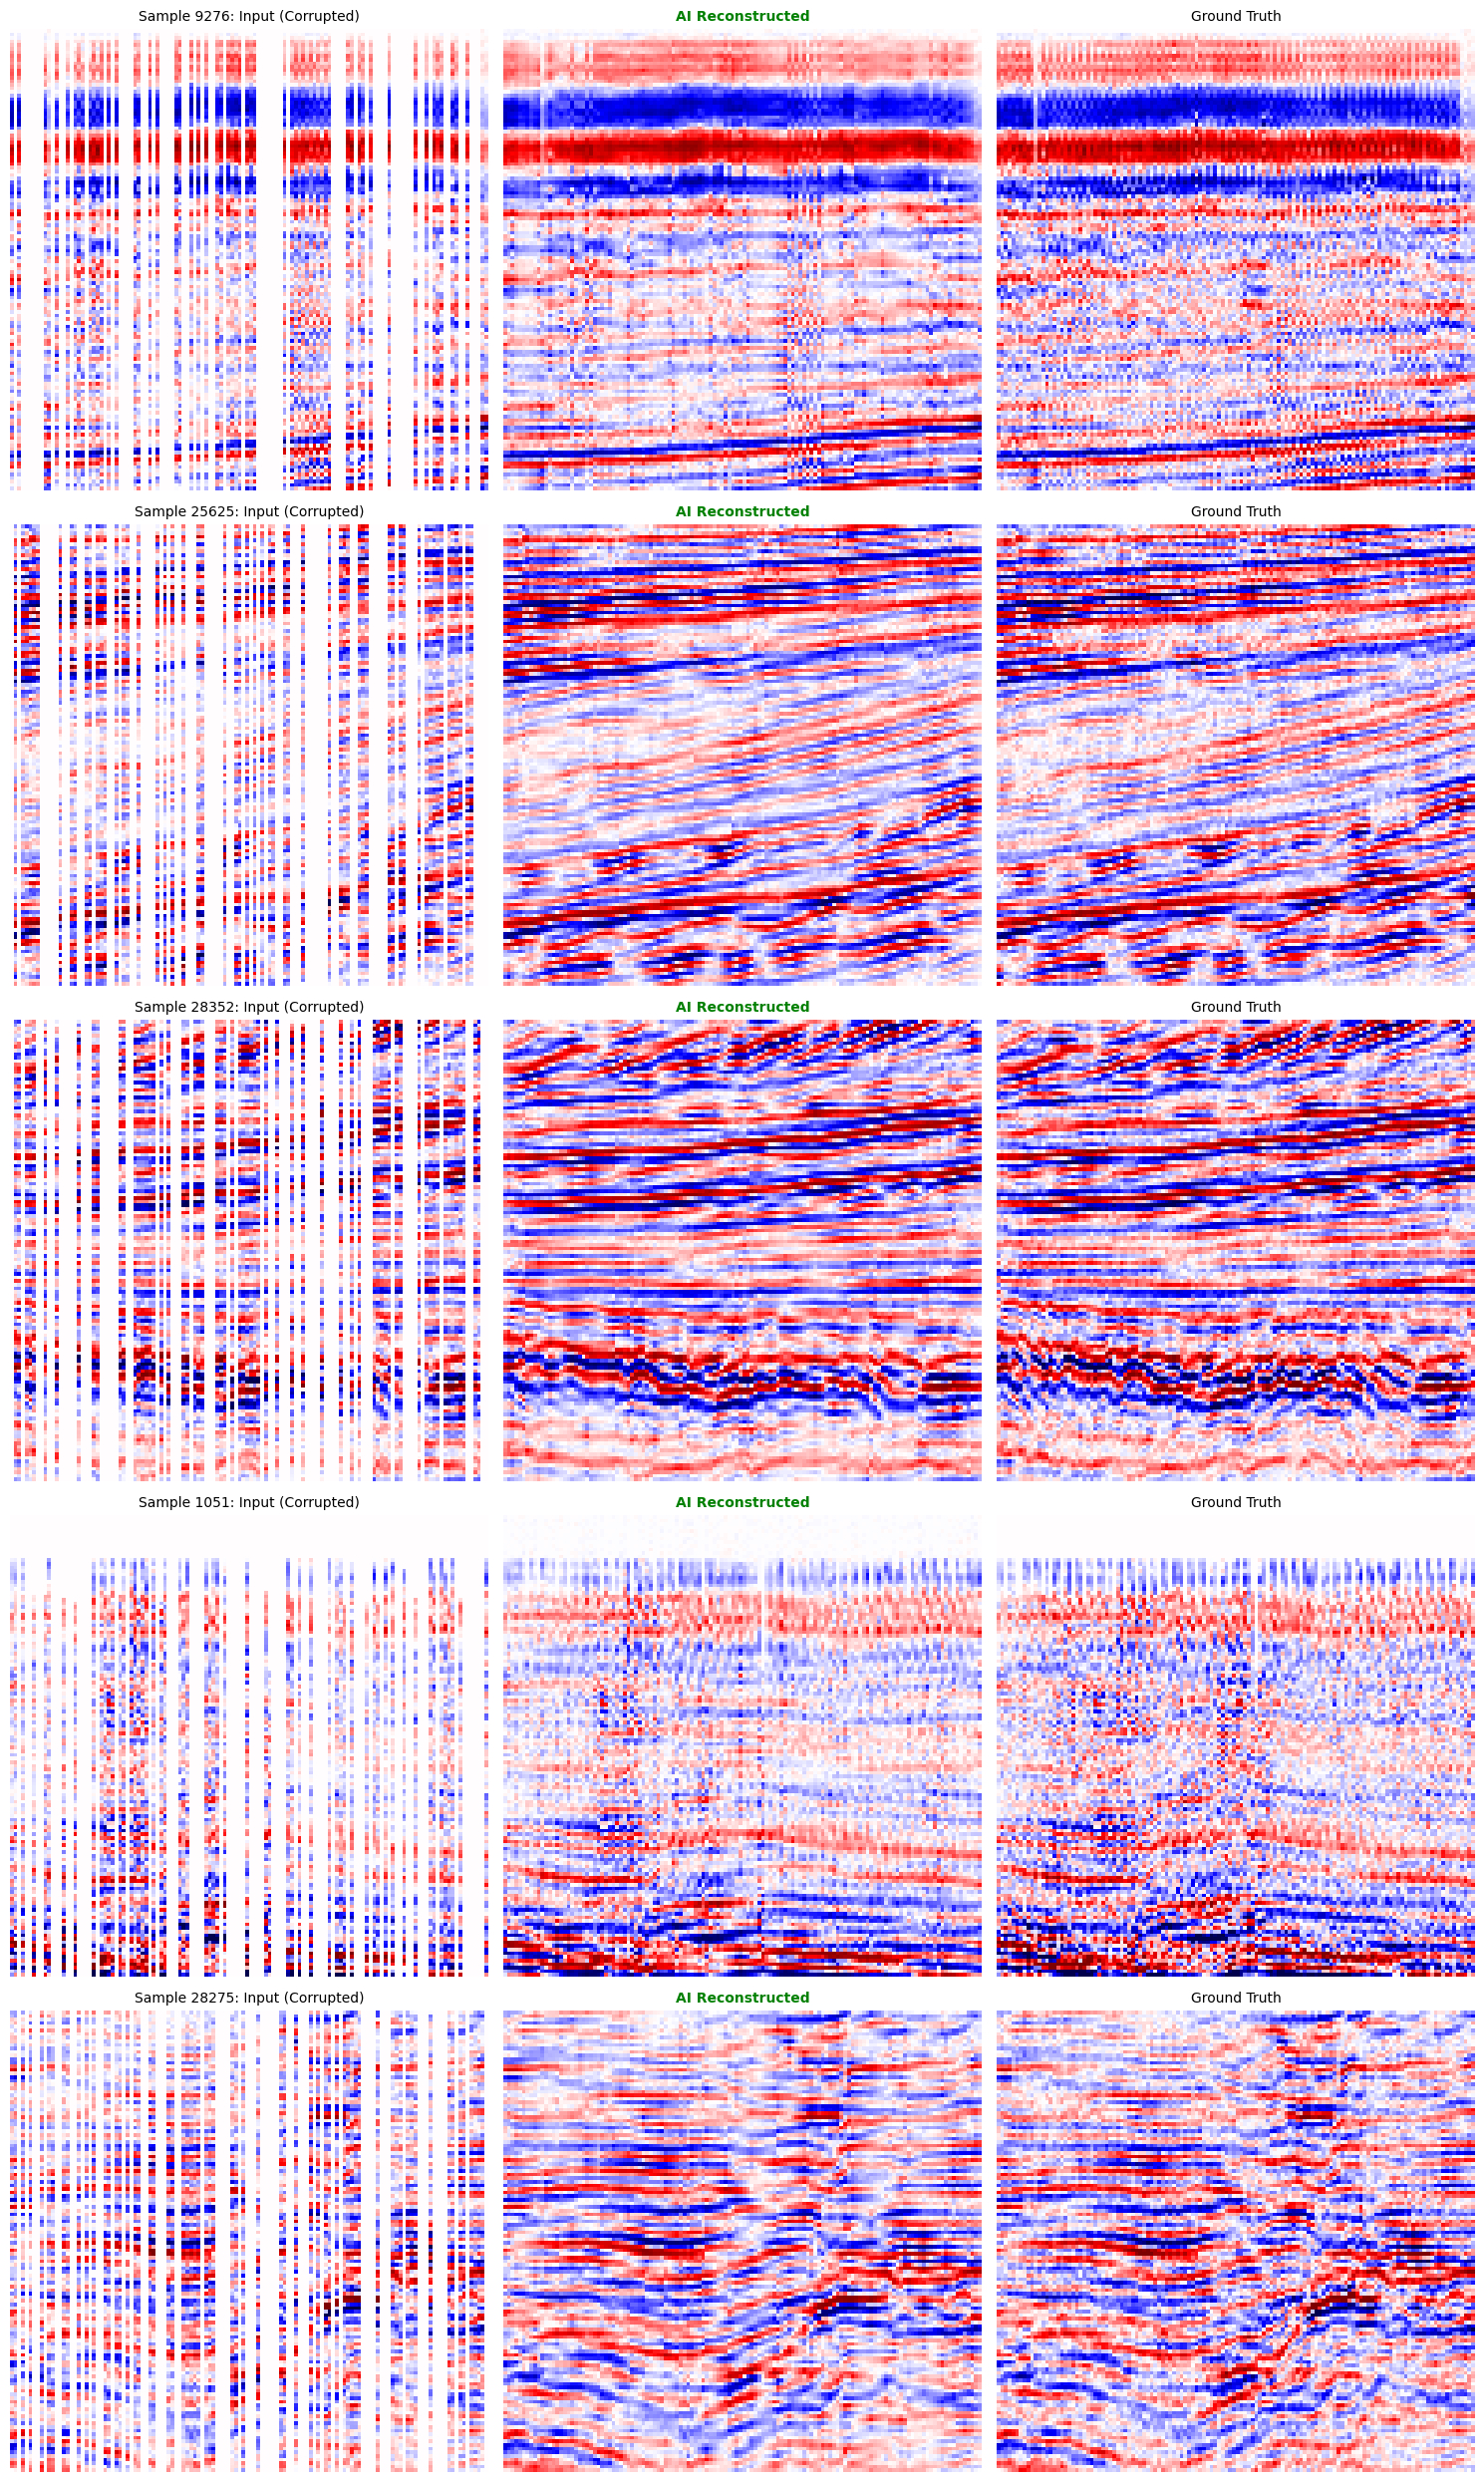

In [10]:
# @title 5. Live Demo: Random 5 Training Validation
def show_demo_results(model, dataset, num_samples=5):
    if dataset is None: return
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            inputs, target = dataset[idx]
            input_tensor = inputs.unsqueeze(0).to(ProjectConfig.DEVICE).float()

            reconstructed = model(input_tensor)

            img_in = inputs[0].cpu().numpy()
            img_target = target[0].cpu().numpy()
            img_pred = reconstructed[0, 0].cpu().numpy()

            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(img_in, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title(f"Sample {idx}: Input (Corrupted)", fontsize=10)
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(img_pred, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title("AI Reconstructed", fontsize=10, color='green', fontweight='bold')
            plt.axis('off')

            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(img_target, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title("Ground Truth", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

if full_data is not None:
    show_demo_results(generator, dataset)

Processing sample2.png at FULL RESOLUTION...


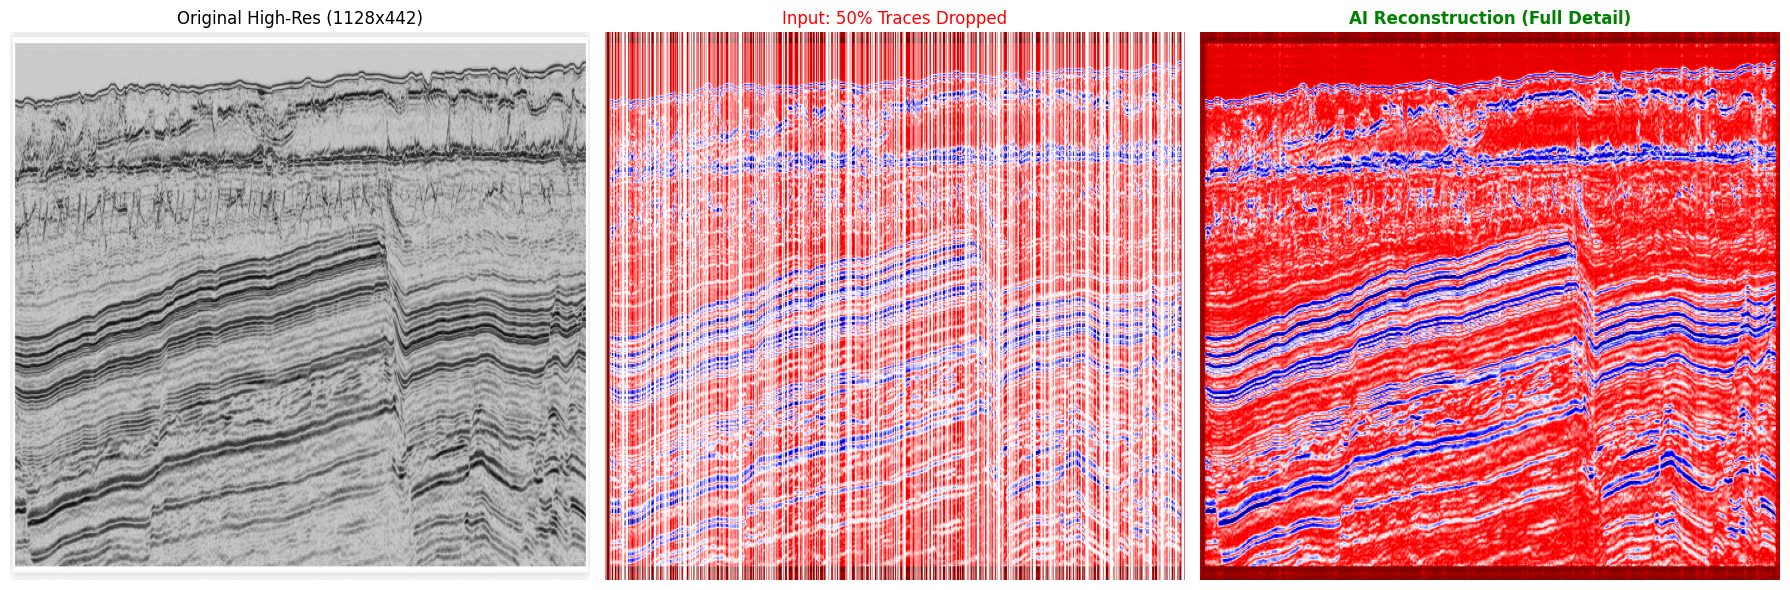

In [15]:
# @title 7. Test Local File (High-Resolution Support)
def test_local_file_high_res(filename="sample.png"):
    """
    Intelligent High-Res Inference:
    Pads the image to be divisible by 32, reconstructs it, then crops back.
    Does NOT shrink or blur the image.
    """
    if not os.path.exists(filename):
        print(f"❌ Error: '{filename}' not found.")
        return

    print(f"Processing {filename} at FULL RESOLUTION...")

    # 1. Load Original
    img_pil = Image.open(filename).convert('L')
    original_w, original_h = img_pil.size

    # 2. Convert to Tensor (No Resizing)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    input_tensor = transform(img_pil).unsqueeze(0) # (1, 1, H, W)

    # 3. Intelligent Padding (Must be divisible by 32 for U-Net)
    h, w = input_tensor.shape[2], input_tensor.shape[3]
    pad_h = (32 - h % 32) % 32
    pad_w = (32 - w % 32) % 32

    padded_tensor = F.pad(input_tensor, (0, pad_w, 0, pad_h), mode='reflect')

    # 4. Create Corruption Mask on Full Size
    clean_numpy = padded_tensor.squeeze().numpy()
    corrupted_numpy, mask_numpy = apply_random_trace_corruption(clean_numpy, drop_prob=0.5)

    # 5. Predict
    generator.eval()
    with torch.no_grad():
        inp = torch.from_numpy(corrupted_numpy).unsqueeze(0).unsqueeze(0)
        msk = torch.from_numpy(mask_numpy).unsqueeze(0).unsqueeze(0)

        # Input: (1, 2, H_padded, W_padded)
        model_input = torch.cat([inp, msk], dim=1).to(ProjectConfig.DEVICE).float()

        # Run U-Net
        reconstruction = generator(model_input)

        # 6. Crop back to original size
        result_tensor = reconstruction[0, 0, :h, :w]
        result_numpy = result_tensor.cpu().numpy()
        corrupted_display = corrupted_numpy[:h, :w]

    # 7. Visualize
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(clean_numpy[:h, :w], cmap='gray', aspect='auto')
    plt.title(f"Original High-Res ({original_w}x{original_h})", fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(corrupted_display, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
    plt.title("Input: 50% Traces Dropped", fontsize=12, color='red')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_numpy, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
    plt.title("AI Reconstruction (Full Detail)", fontsize=12, color='green', fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run it
test_local_file_high_res("sample2.png")

Selecting 5 random samples from your SEG-Y file...


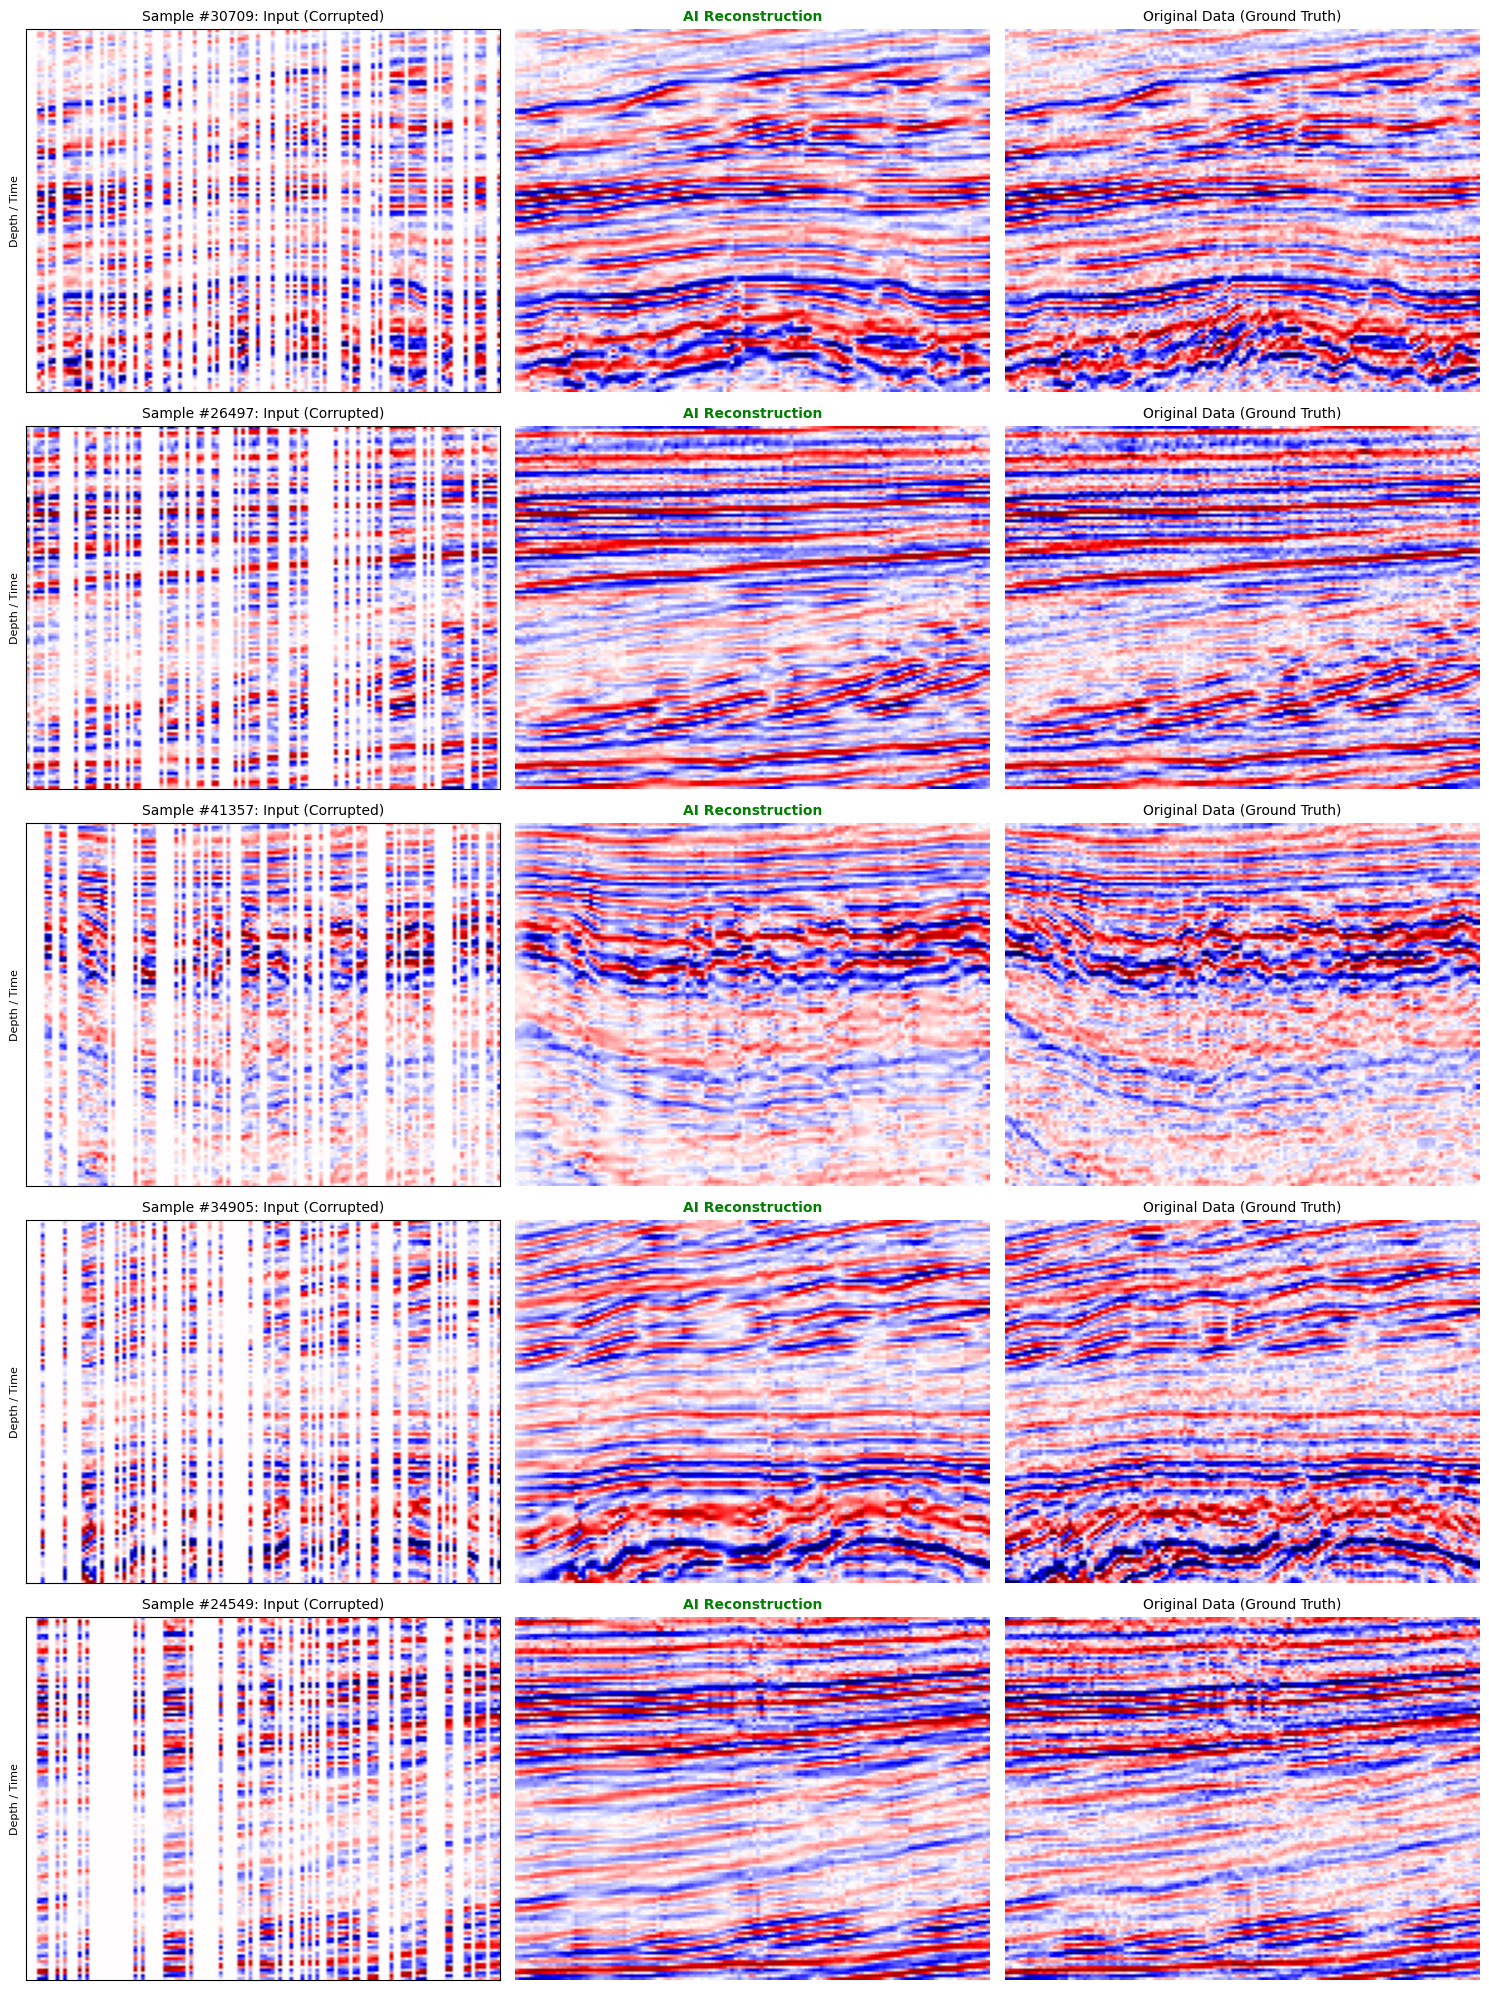

In [17]:
# @title 6. Test on Original SEG-Y Data (Random Samples)
import random

def test_segy_samples(num_samples=5):
    """
    Picks random patches from your loaded SEG-Y file and
    compares AI reconstruction vs. Reality.
    """
    # Check if data exists
    if 'dataset' not in globals() or dataset is None:
        print("❌ Error: SEG-Y dataset not loaded. Please run Cell 2 first.")
        return

    print(f"Selecting {num_samples} random samples from your SEG-Y file...")

    # Switch model to evaluation mode (no learning, just predicting)
    generator.eval()

    # Pick random indices from the dataset
    indices = random.sample(range(len(dataset)), num_samples)

    # Create the figure
    plt.figure(figsize=(15, 4 * num_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Get Data from Dataset
            # inputs contains: [Corrupted_Image, Mask]
            # target contains: [Clean_Image]
            inputs, target = dataset[idx]

            # 2. Prepare for Model
            # Add batch dimension: (1, 2, 128, 128)
            input_tensor = inputs.unsqueeze(0).to(ProjectConfig.DEVICE).float() # Cast to float32

            # 3. Run AI Prediction
            reconstruction = generator(input_tensor)

            # 4. Extract arrays for plotting
            # Input channel 0 is the corrupted image
            img_corrupted = inputs[0].cpu().numpy()
            img_ai = reconstruction[0, 0].cpu().numpy()
            img_original = target[0].cpu().numpy()

            # 5. Visualization
            # Row i, Column 1: Corrupted
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(img_corrupted, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title(f"Sample #{idx}: Input (Corrupted)", fontsize=10)
            plt.ylabel("Depth / Time", fontsize=8)
            plt.axis('on')
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Row i, Column 2: AI Result
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(img_ai, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title("AI Reconstruction", fontsize=10, color='green', fontweight='bold')
            plt.axis('off')

            # Row i, Column 3: The Truth
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(img_original, cmap='seismic', aspect='auto', vmin=-1, vmax=1)
            plt.title("Original Data (Ground Truth)", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the test
test_segy_samples(5)